# Minprj : sentiment analysis

>date : 28 oct 2021<br>
author : bae hueng myoung<br>
e-mail : naroo135@gmail.com<br>
p.s. : 추후 colab으로 이전하여야 함

# overview

## work(1) : data load

In [62]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/Exp07_sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Exp07_sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### anlaysis : 네이버 댓글을 보면 정말 매우 짧은 댓글들과 깊이 있는 감상 분석이 없는 것을 확인할 수 있다.₩

## work(2) : preprocessing

### work(2)-1 : removing of missing data 

In [63]:
train_data.isnull().sum()
train_data = train_data.dropna()
train_data.info()
train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


id          0
document    0
label       0
dtype: int64

In [64]:
test_data.isnull().sum()
test_data = test_data.dropna()
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

### work(2)-2 : toknizing && removing of not used words && word dict && split train and test

In [65]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [66]:
print('X_train num : ',len(X_train))
print('X_test num : ',len(X_test))
print('y_train num : ',len(y_train))
print('y_test num : ',len(y_test))

X_train num :  146182
X_test num :  49157
y_train num :  146182
y_test num :  49157


In [67]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [68]:

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word[4]

'.'

In [92]:
len(index_to_word)
vocab_size = len(index_to_word)
vocab_size

10000

In [70]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [71]:
encoded_sentence = X_train[0]
get_decoded_sentence(encoded_sentence, index_to_word)

'더 빙 . . 진짜 짜증 나 네요 목소리'

## work(2)-3 : sutiable for max length of sentence and padding

In [91]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

word_vector_dim = maxlen

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0
pad_sequences maxlen :  41
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


In [93]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


#### analysis : LMS에서 배웠듯 문장의 중요 의미는 대체로 문장의 끝 부분에 위치할 가능성이 높습니다. 따라서 padding은 뒷부분보다 앞 부분에 하는 것이 적절ㅎ하다.

#### anlysis : train set의 갯수가 14만 정도이므로 20%를 validation set으로 구성

In [94]:
val_num = int(0.3*len(X_train))
print('valdation num :',val_num)
print('x train num : ',len(X_train))

# validation set 29236건 분리
x_val = X_train[:val_num]   
y_val = y_train[:val_num]

print(len(x_val))
print(len(y_val))
# validation set을 제외한 나머지 
partial_x_train = X_train[val_num:]  
partial_y_train = y_train[val_num:]

print(partial_x_train.shape)
print(partial_y_train.shape)

valdation num : 43854
x train num :  146182
43854
43854
(102328, 41)
(102328,)


In [95]:
vocab_size
word_vector_dim

41

## work(3) : model design

모델은 총 3가지의 모델을 이용하였다. CNN계열의 globalMaxpooling1D의 레이어만으로 구성된 모델, RNN계열의 LSTM레이어만으로 구성된 모델, 

### model (1) : globalMaxpolling1D

In [98]:

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_max.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 41)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 336       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


### model (2) : Convolutional1D model

In [111]:
model_conv = keras.Sequential()
model_conv.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_conv.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다

model_conv.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 41)          410000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          4608      
Total params: 414,608
Trainable params: 414,608
Non-trainable params: 0
_________________________________________________________________


### model (3) : combination of conv1D, maxpooling model

In [105]:
# model 3: Conv1D and GlobalMaxPooling
model_comb = keras.Sequential()
model_comb.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_comb.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_comb.add(keras.layers.MaxPooling1D(5))
model_comb.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_comb.add(keras.layers.GlobalMaxPooling1D())
model_comb.add(keras.layers.Dense(8, activation='relu'))
model_comb.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_comb.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 41)          410000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

### model (4) : RNN LSTM model

In [106]:


model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 41)          410000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 1600      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


## work(4) : model Trainning

In [101]:
def model_trainning(model,partial_x_train,partial_y_train,x_val, y_val):

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
    epochs=20
    history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
    return history

In [108]:
history_max = model_trainning(model_max,partial_x_train,partial_y_train,x_val, y_val)

Epoch 1/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0302 - accuracy: 0.9925 - val_loss: 0.9210 - val_accuracy: 0.8170
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0266 - accuracy: 0.9932 - val_loss: 0.9544 - val_accuracy: 0.8142
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0254 - accuracy: 0.9939 - val_loss: 0.9930 - val_accuracy: 0.8135
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0227 - accuracy: 0.9943 - val_loss: 1.0295 - val_accuracy: 0.8126
Epoch 5/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0194 - accuracy: 0.9949 - val_loss: 1.0597 - val_accuracy: 0.8107
Epoch 6/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0199 - accuracy: 0.9948 - val_loss: 1.0896 - val_accuracy: 0.8096
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0169 - accuracy: 0.9954 - val_loss: 1.1259 - val_accuracy: 0.8095
Epoch 

In [112]:
history_conv = model_trainning(model_conv,partial_x_train,partial_y_train,x_val, y_val)

Epoch 1/20


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Incompatible shapes: [512,1] vs. [512,35,16]
	 [[node binary_crossentropy/mul (defined at <ipython-input-101-61349d148d49>:13) ]]
	 [[gradient_tape/sequential_15/embedding_15/embedding_lookup/Reshape/_38]]
  (1) Invalid argument:  Incompatible shapes: [512,1] vs. [512,35,16]
	 [[node binary_crossentropy/mul (defined at <ipython-input-101-61349d148d49>:13) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_72028]

Function call stack:
train_function -> train_function


In [110]:
history_comb = model_trainning(model_comb,partial_x_train,partial_y_train,x_val, y_val)


Epoch 1/20
200/200 [==============================] - 10s 35ms/step - loss: 0.5983 - accuracy: 0.6636 - val_loss: 0.3535 - val_accuracy: 0.8461
Epoch 2/20
200/200 [==============================] - 2s 12ms/step - loss: 0.3205 - accuracy: 0.8650 - val_loss: 0.3353 - val_accuracy: 0.8530
Epoch 3/20
200/200 [==============================] - 2s 12ms/step - loss: 0.2685 - accuracy: 0.8916 - val_loss: 0.3356 - val_accuracy: 0.8551
Epoch 4/20
200/200 [==============================] - 2s 12ms/step - loss: 0.2213 - accuracy: 0.9149 - val_loss: 0.3579 - val_accuracy: 0.8500
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 0.1683 - accuracy: 0.9408 - val_loss: 0.3890 - val_accuracy: 0.8476
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 0.1223 - accuracy: 0.9599 - val_loss: 0.4416 - val_accuracy: 0.8453
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0865 - accuracy: 0.9737 - val_loss: 0.5016 - val_accuracy: 0.839

In [113]:
history_RNN = model_trainning(model_RNN,partial_x_train,partial_y_train,x_val, y_val)

Epoch 1/20
200/200 [==============================] - 5s 15ms/step - loss: 0.6030 - accuracy: 0.7014 - val_loss: 0.3713 - val_accuracy: 0.8397
Epoch 2/20
200/200 [==============================] - 3s 13ms/step - loss: 0.3432 - accuracy: 0.8572 - val_loss: 0.3517 - val_accuracy: 0.8476
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 0.3083 - accuracy: 0.8748 - val_loss: 0.3491 - val_accuracy: 0.8504
Epoch 4/20
200/200 [==============================] - 3s 13ms/step - loss: 0.2965 - accuracy: 0.8806 - val_loss: 0.3529 - val_accuracy: 0.8489
Epoch 5/20
200/200 [==============================] - 3s 13ms/step - loss: 0.2821 - accuracy: 0.8868 - val_loss: 0.3565 - val_accuracy: 0.8500
Epoch 6/20
200/200 [==============================] - 3s 13ms/step - loss: 0.2690 - accuracy: 0.8925 - val_loss: 0.3582 - val_accuracy: 0.8495
Epoch 7/20
200/200 [==============================] - 3s 13ms/step - loss: 0.2522 - accuracy: 0.9021 - val_loss: 0.3627 - val_accuracy: 0.8498

## work(5) : model evaluation

In [118]:
def model_evaluation(model):
    results = model.evaluate(X_test,  y_test, verbose=2)
    return results

In [121]:
print('model max : ',model_evaluation(model_max))
#print('model max : ',model_evaluation(model_conv))
print('model comb : ',model_evaluation(model_comb))
print('model RNN : ',model_evaluation(model_RNN))

1537/1537 - 2s - loss: 1.5034 - accuracy: 0.7993
model max :  [1.5034122467041016, 0.799275815486908]
1537/1537 - 3s - loss: 1.0722 - accuracy: 0.8161
model comb :  [1.0721900463104248, 0.8161401152610779]
1537/1537 - 5s - loss: 0.5445 - accuracy: 0.8364
model RNN :  [0.5445128083229065, 0.8363813757896423]


In [130]:
def graphic(history,model_name):
    history_dict = history.history
    print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss'+model_name)
    plt.title('Training and validation loss '+model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    
    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy '+ model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


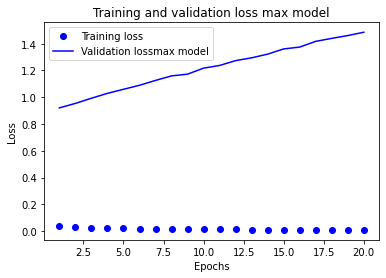

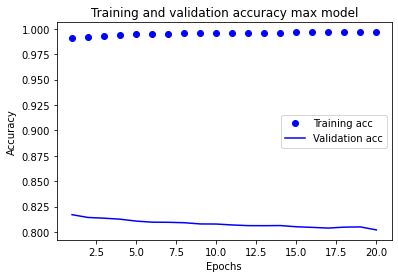

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


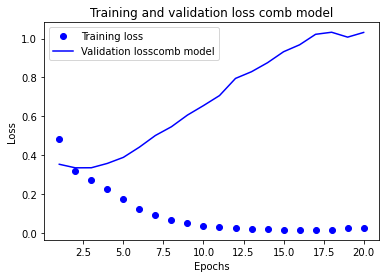

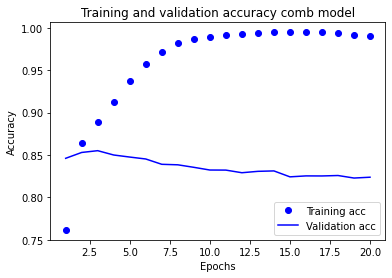

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


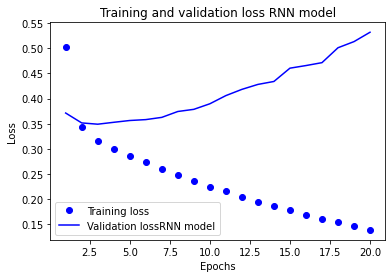

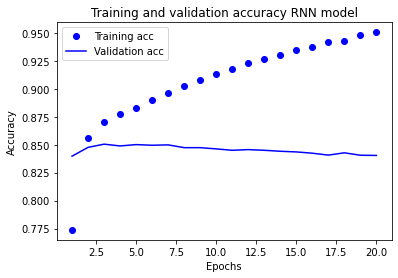

In [131]:
graphic(history_max,'max model')
#graphic(history_conv)
graphic(history_comb,'comb model')
graphic(history_RNN,'RNN model')

#### anlysis : 
각 모델의 자체 임베딩 레이어를 활용하였을 때 오버피팅이 심하게 나타남을 찾아볼 수 있다. maxpooling모델은 trainning acc가 epoch횟수가 적은 시작부분붙터 정확도가 거의 1에 가깝고 validation과의 눈에 띄는 유격을 보여준다. 다른 모델들도 전반적으로 trainning과 validation의 acc의 유격을 보여주며 전반적으로 0.25의 큰 폭의 결과를 보여주고 있다. 이는 네이버 댓글의 단어의 데이터의 양이 매우 적어 충분한 학습을 하지 못했기 때문임을 추측해볼 수 있다. 

## work(6) : trainning embedding model anlaysis

In [132]:
def model_embedding_layer(model):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [133]:
model_embedding_layer(model_max)
model_embedding_layer(model_comb)
model_embedding_layer(model_RNN)

(10000, 41)
(10000, 41)
(10000, 41)


#### anlysis : 3가지 모델은 각각 vocab size=10000개와 dim=41으로 학습된 모습을 보여주고 있다. 이 결과는 각 모델이 네이버 댓글의 데이터셋으로 학습을 하였고 단어들의 최적의 embedding값을 계산한 결과이다. 각 모델이 학습한 임베딩 모델의 결과를 저장할 것이다.

In [138]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

def Embedding_save(model,model_name):

    word2vec_file_path = os.getenv('HOME')+'/aiffel/Exp07_sentiment_classification/data/'+model_name+'.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    return word2vec_file_path

In [143]:
def similary_print(word2vec_file_path,enter_word):
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    similar_word = word_vectors.similar_by_word(enter_word)
    print(similar_word)

In [146]:
enter_word = '사랑'
similary_print(Embedding_save(model_max, 'model_max'),enter_word)


[('비디오', 0.829888105392456), ('극', 0.8183358907699585), ('교과서', 0.7987573742866516), ('은지', 0.7951825261116028), ('됨', 0.792548418045044), ('아름다웠', 0.7907727360725403), ('롭', 0.7907196879386902), ('임팩트', 0.7892364859580994), ('아프', 0.7874290943145752), ('담', 0.7858216166496277)]


In [147]:
similary_print(Embedding_save(model_comb, 'model_comb'),enter_word)


[('걸림', 0.6758061647415161), ('펼쳐지', 0.6698821783065796), ('브래드피트', 0.6545907258987427), ('유동근', 0.653839647769928), ('김남길', 0.651508092880249), ('에여', 0.6511815786361694), ('실감', 0.6396427154541016), ('신성', 0.6377354264259338), ('돌이켜', 0.6371643543243408), ('색다르', 0.631227970123291)]


In [148]:
similary_print(Embedding_save(model_RNN, 'model_RNN'),enter_word)

[('소장', 0.9183174967765808), ('훈훈', 0.9146788716316223), ('명작', 0.9142971038818359), ('웨스턴', 0.9107950329780579), ('게이트', 0.910603404045105), ('끝장', 0.9090138673782349), ('눈물', 0.9044554233551025), ('깊', 0.9031424522399902), ('여운', 0.9015349745750427), ('빠져들', 0.9012458324432373)]


    #### analysis : '사랑'이라는 키워드를 입력하였을 때 3가지 모델 모두 유사성이 높은 단어들을 출력하였고 각기 다른 결과들을 보여주었다. 자체 학습된 임베딩의 결과는 그리 성능이 좋아보이지 않는다. 사랑과 관련없는 비디오,교과서,김남길 등의 단어들이 리스트에 보이기 때문이다. 이는 학습한 데이터는 네이버의 댓글의 한계성 때문이다. 제한된 단어의 학습은 단어의 유사성이 실제 사람이 쓰는 방대한 양에 대한 학습에 의한 유사성보다 퀄리티가 떨어지는 것은 당연하다. 이러한 임베딩 성능의 한계는 댓글의 내용이 부정인지 긍정인지에 대한 성능에 영향을 미친다. 위에서 살펴본 것과 같이 3가지 모델 모두 validation과 trainning의 accuracy와 loss가 유격되어 학습이 성공적으로 이루어졌다고 보기 어려웠다. 따라서 학습의 성공률을 높이기 위해서 방대한 한글 사전이 담긴 ko.bin의 임베딩 모델을 활용하여 얼마나 성능 개선이 이루어졌는지 알아볼 것이다.

## work (7) getting of ko.bin embbeding model

gensim version이 높을 때 한글 임베딩을 불러올 때 utf-8의 오류가 발생한다.<br>
이러한 문제는 버전의 특성 문제이며 다운 그레이드를 통해 이를 해결하였다.<br>
`pip install --upgrade gensim==3.8.3` 이 커맨드는 gensim의 다운그레이드버전을 다시 설치해주는 명령어이다.

In [172]:
import os
#from gensim.models import KeyedVectors
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/Exp07_sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['행복']
vector 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-9.37647521e-01,  3.84321630e-01,  2.66711020e+00, -4.90441829e-01,
       -1.87378454e+00,  7.46136725e-01,  2.06848055e-01,  1.17018402e+00,
        1.76071718e-01,  3.52754295e-01,  3.27339917e-01,  6.24713361e-01,
        4.98253882e-01, -2.54079252e-01,  1.86370641e-01,  5.02261400e-01,
        5.70066161e-02,  1.03963447e+00,  4.08005528e-02,  8.49552810e-01,
       -1.51971027e-01,  1.52919903e-01,  4.23378617e-01,  1.98788300e-01,
        1.94235623e+00, -2.86525309e-01,  4.72732335e-01, -2.14849854e+00,
       -1.26080573e+00, -1.48370254e+00, -7.26968274e-02, -5.65377235e-01,
       -1.09561288e+00, -8.93630147e-01,  8.22069585e-01, -4.43008691e-01,
        6.42822444e-01, -1.16659820e+00,  1.46968305e+00,  3.69109273e+00,
       -3.84803802e-01,  1.05108881e+00,  2.13611469e-01, -1.45143092e+00,
        5.02505243e-01,  7.05544576e-02,  1.83592427e+00, -6.79975271e-01,
        3.81043881e-01,  2.86220014e-01, -3.55438769e-01,  4.01191115e-02,
       -2.18128219e-01,  

In [173]:
vector.shape

(200,)

#### anlaysis : 한글 임베딩 모델은 200차원의 임베딩 값으로 구성되어 있다. 

In [149]:
word2vec.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

#### analysis : 한글 ko.bin 임베딩 모델을 이용하였을 때 사랑을 검색해본 결과 유사성은 자체 학습된 임베딩의 결과보다 훨씬 성능이 좋아보인다. 슬픔, 행복, 절망, 기쁨 등 사랑과 관련된 감정의 상태의 단어들을 출력해주었고 이는 댓글의 긍정성과 부정성의 성향을 나누는데 모델의 학습률을 개선시켜줄 것으로 기대된다.

## work(8) : applying korean lan embedding model to machine learning

한국어 word2vec을 이용하여 앞서 진행했던 모델의 임베딩 레이어에 새로 적용하여 모델의 성능이 얼마나 개선되었는지 모델별로 비교해볼 것이다.
(work(8)은 한글 word2vec의 임베딩 모델을 뉴럴 네트워크에 쌓아 작동하는지 시험해보는 과정이다. 앞선 모델과의 비교용도가 아님을 미리 밝힌다.)

### work(8) - 1 : getting embedding

In [195]:
vocab_size_ko = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim_ko = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size_ko, word_vector_dim_ko)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size_ko):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### work(8) - 2 : applying of embedding matrix(korean word2vec)



In [187]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size_ko, 
                                 word_vector_dim_ko, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(keras.layers.MaxPooling1D(5))
model_ko.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(keras.layers.GlobalMaxPooling1D())
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid')) 

model_ko.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [188]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 12s 48ms/step - loss: 0.6621 - accuracy: 0.6040 - val_loss: 0.4628 - val_accuracy: 0.7855
Epoch 2/20
200/200 [==============================] - 7s 33ms/step - loss: 0.4247 - accuracy: 0.8065 - val_loss: 0.3924 - val_accuracy: 0.8254
Epoch 3/20
200/200 [==============================] - 7s 33ms/step - loss: 0.3500 - accuracy: 0.8484 - val_loss: 0.3686 - val_accuracy: 0.8375
Epoch 4/20
200/200 [==============================] - 7s 33ms/step - loss: 0.3032 - accuracy: 0.8720 - val_loss: 0.3624 - val_accuracy: 0.8435
Epoch 5/20
200/200 [==============================] - 7s 34ms/step - loss: 0.2675 - accuracy: 0.8903 - val_loss: 0.3667 - val_accuracy: 0.8436
Epoch 6/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2374 - accuracy: 0.9057 - val_loss: 0.3809 - val_accuracy: 0.8411
Epoch 7/20
200/200 [==============================] - 7s 34ms/step - loss: 0.2144 - accuracy: 0.9182 - val_loss: 0.4000 - val_accuracy: 0.840

In [190]:
results = model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.8646 - accuracy: 0.8205
[0.8646066188812256, 0.8204935193061829]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


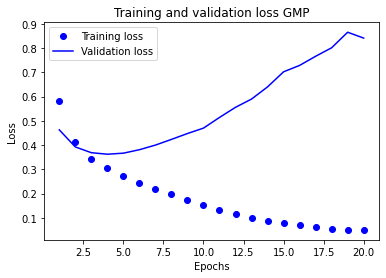

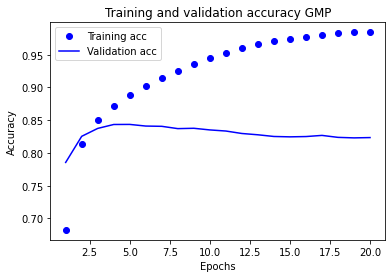

In [191]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
    
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss '+model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

    
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy '+ model_name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## work(9) : applying ko_word2vec : model design && model trainning && model evaluationnn

In [198]:

## 한글 word2vec이 적용된 새로운 모델 디자인 : globalmax based on ko_word2vec
model_max_ko = keras.Sequential()
model_max_ko.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max_ko.add(keras.layers.GlobalMaxPooling1D())
model_max_ko.add(keras.layers.Dense(8, activation='relu'))
model_max_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_max_ko.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 2300)        23000000  
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 2300)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 18408     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 23,018,417
Trainable params: 23,018,417
Non-trainable params: 0
_________________________________________________________________


In [199]:
## 한글 word2vec이 적용된 새로운 모델 디자인 : combination of conv1d and maxpool based on ko_word2vec
model_comb_ko = keras.Sequential()
model_comb_ko.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_comb_ko.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_comb_ko.add(keras.layers.MaxPooling1D(5))
model_comb_ko.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_comb_ko.add(keras.layers.GlobalMaxPooling1D())
model_comb_ko.add(keras.layers.Dense(8, activation='relu'))
model_comb_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_comb_ko.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 2300)        23000000  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 16)          257616    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [200]:
model_RNN_ko = keras.Sequential()
model_RNN_ko.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN_ko.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN_ko.add(keras.layers.Dense(8, activation='relu'))
model_RNN_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN_ko.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 2300)        23000000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 73888     
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 23,073,969
Trainable params: 23,073,969
Non-trainable params: 0
_________________________________________________________________


In [201]:
history_max_ko = model_trainning(model_max_ko,partial_x_train,partial_y_train,x_val, y_val)
history_comb_ko = model_trainning(model_comb_ko,partial_x_train,partial_y_train,x_val, y_val)
history_RNN_ko = model_trainning(model_RNN_ko,partial_x_train,partial_y_train,x_val, y_val)

      

Epoch 1/20
200/200 [==============================] - 76s 375ms/step - loss: 0.6188 - accuracy: 0.6612 - val_loss: 0.4865 - val_accuracy: 0.8412
Epoch 2/20
200/200 [==============================] - 75s 377ms/step - loss: 0.4479 - accuracy: 0.8661 - val_loss: 0.3431 - val_accuracy: 0.8511
Epoch 3/20
200/200 [==============================] - 75s 375ms/step - loss: 0.2645 - accuracy: 0.8985 - val_loss: 0.3417 - val_accuracy: 0.8547
Epoch 4/20
200/200 [==============================] - 75s 376ms/step - loss: 0.1978 - accuracy: 0.9293 - val_loss: 0.3670 - val_accuracy: 0.8533
Epoch 5/20
200/200 [==============================] - 75s 375ms/step - loss: 0.1331 - accuracy: 0.9574 - val_loss: 0.4099 - val_accuracy: 0.8505
Epoch 6/20
200/200 [==============================] - 75s 375ms/step - loss: 0.0752 - accuracy: 0.9806 - val_loss: 0.4569 - val_accuracy: 0.8487
Epoch 7/20
200/200 [==============================] - 75s 376ms/step - loss: 0.0391 - accuracy: 0.9908 - val_loss: 0.5180 - val_ac

In [202]:
print('model max ko version : ',model_evaluation(model_max_ko))
print('model comb ko version : ',model_evaluation(model_comb_ko))
print('model RNN ko version : ',model_evaluation(model_RNN_ko))

                                     

1537/1537 - 5s - loss: 0.8506 - accuracy: 0.8454
model max ko version :  [0.8506183624267578, 0.8453526496887207]
1537/1537 - 10s - loss: 1.2145 - accuracy: 0.8267
model comb ko version :  [1.2144966125488281, 0.8267184495925903]
1537/1537 - 9s - loss: 0.7975 - accuracy: 0.8291
model RNN ko version :  [0.797534167766571, 0.8290579319000244]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


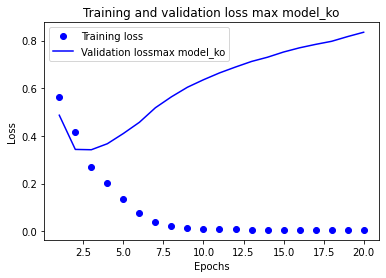

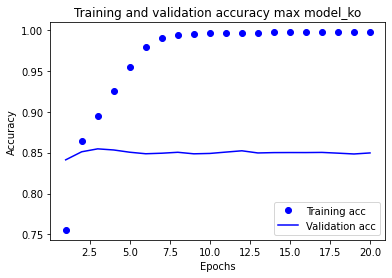

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


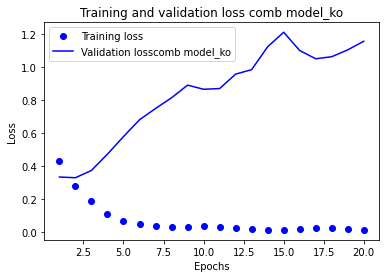

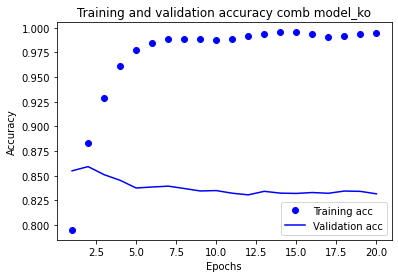

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


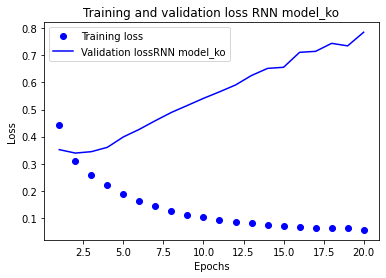

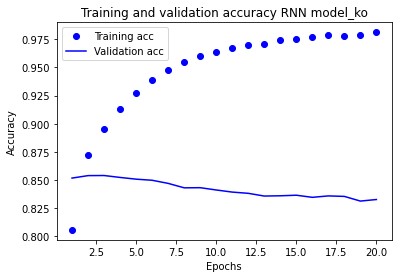

In [203]:
graphic(history_max_ko,'max model_ko')
graphic(history_comb_ko,'comb model_ko')
graphic(history_RNN_ko,'RNN model_ko')

## Anlalysis

머신러닝에 자체 엠베딩 레이어를 쌓아 네이버 댓글을 학습시켰을 때와 word2vec한글을 엠베딩 레이어에 적용시켜 학습했을 때 test 결과는 다음과 같다.

| model | 자체 엠베딩 loss | 자체 임베딩 accuracy |word2vec엠베딩 loss |word2vec엠베딩 accuracy |
|:-------|:---------|:---------|:------|:------|
|maxpooling1D applying | 1.5034 |0.7993 | 0,8506 | 0.8454 |
|maxpooling1D&conv1D applying | 1.0722 |0.8161 |1.2145 | 0.8267 |
|RNN applying | 0.5445 | 0.8314 | 0.7975 |0,8291 |



테스트의 차이는 미비하지만 약간의 변화는 확인하였다. maxpooling1D만 적용한 모델과 convolution1D를 같이 적용한 모델은 test accuracy가 소폭 상승한 결과를 보여주었다. 반면 기대했던 RNN적용한 모델은 오히려 accuracy가 감소하는 결과를 보여주었다. 이러한 결과들에 대해 자체 임베딩과 word2vec을 적용한 임베딩의 차이를 설명하기엔 무리가 있다. 그 이유는 학습 과정에서 validation과 trainning의 loss, accuracy곡선의 격차가 학습의 성공보단 실패에 가깝게 보이기 때문이다. 다만, word2vec을 적용하였을 때 maxpooling에서는 epoch횟수 처음 시작부터 큰 폭을 유지했지만 word2vec을 적용하였을 때 epoch 1에서 7까지 점점 유격이 벌어지는 양상으로 변화가 있었다. 그리고 눈에 띄는 다른 변하는 거의 찾아보기 힘들다. 


## Conclusion

우리가 알아보고자 했던 자체 임베딩 모델과 word2vec 임베딩 모델을 적용하였을 때 모델의 성능개선이 얼마나 잘 이루어졌는지를 파악하는 것은 실패하였다. 예상과 달리 모델의 학습이 성공적으로 잘 수행되지 않았으며 word2vec을 적용하지 않았을 때와 적용했을 때의 차이는 극히 미비하였기 때문이다. 이러한 문제에 대해서 모델의 성능을 개선하기 위한 다른 조치가 필요함을 느끼게 되었다. 언어를 이해할 때 이전의 경험적 기억들을 리콜(recall)하고 적절한 단어들의 유사성을 평가하는 고도의 지적처리에는 RNN 계열의 뉴럴네트워크레이어를 쓴다고 한다. 하지만 RNN은 long term dependency의 문제점을 갖고 있고 보완할 수 있는 알고리즘을 이번 프로젝트에서 적용하지 못했다. 따라서 이번 프로젝트의 실패에 대해서 모델의 성능 개선에 대한 조치와 해결을 통해 얼마나 잘 학습된 모델을 설계하느냐가 우선 과제로 주어져야 한다. 그리고 잘 학습 가능한 모델에 word2vec을 적용할 때와 그렇지 않을 때의 성능변화를 더욱 객관적으로 비교해 볼 수 있을 것이다.
